## Import library

In [42]:
import sys

MAIN_PATH = "/home/trduong/Data/interpretable_machine_learning/Source Code/my_work"


sys.path.insert(
    1,
    MAIN_PATH + '/lib'
)

sys.path.insert(
    1,
    MAIN_PATH + '/config'
)

import numpy as np
import pandas as pd
import logging
import dowhy.datasets
import dowhy
import incremental_ps_score_estimator as ipse
import math
import timeit
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import utils 
from tempfile import TemporaryFile
import experiment_config as cf

# save numpy array as npy file
from numpy import asarray
from numpy import save

from dowhy import CausalModel
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import sem
from dowhy import CausalModel
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from math import sqrt
from econml.dml import LinearDMLCateEstimator
from sklearn.linear_model import LassoCV
from econml.inference import BootstrapInference
from econml.dml import SparseLinearDMLCateEstimator
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import logging
import scipy.stats as st


## Load data 

In [20]:
# Import the sample AB data
file_url = "https://msalicedatapublic.blob.core.windows.net/datasets/RecommendationAB/ab_sample.csv"   
ab_data = pd.read_csv(file_url)

In [21]:
ab_data.head()

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,easier_signup,became_member,days_visited_post
0,1,9,7,25,6,3,1,0.01,0,1,0,0,1
1,10,25,27,10,27,27,0,2.26,0,0,0,0,15
2,18,14,8,4,5,2,1,0.03,0,1,0,0,17
3,17,0,23,2,3,1,1,418.77,0,1,0,0,6
4,24,9,22,2,3,18,1,1.54,0,0,0,0,12


In [22]:
ab_data.shape

In [23]:
ab_data.became_member.value_counts()

0    64780
1    35220
Name: became_member, dtype: int64

In [24]:
ab_data.columns

Index(['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup', 'became_member', 'days_visited_post'],
      dtype='object')

In [25]:
# Define estimator inputs
Z = ab_data['easier_signup'] # nudge, or instrument
T = ab_data['became_member'] # intervention, or treatment
Y = ab_data['days_visited_post'] # outcome of interest
X_data = ab_data.drop(columns=['easier_signup', 'became_member', 'days_visited_post']) # features

col = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup', 'became_member', 'days_visited_post']

cov = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
       'easier_signup']

features = ['days_visited_exp_pre', 'days_visited_free_pre', 'days_visited_fs_pre',
       'days_visited_hs_pre', 'days_visited_rs_pre', 'days_visited_vrs_pre',
       'locale_en_US', 'revenue_pre', 'os_type_osx', 'os_type_windows',
            'became_member']

treatment = 'became_member' # intervention, or treatment
outcome = 'days_visited_post' # outcome of interest




In [26]:
# Define underlying treatment effect function 
TE_fn = lambda X: (0.2 + 0.3 * X['days_visited_free_pre'] - 0.2 * X['days_visited_hs_pre'] + X['os_type_osx']).values
true_TE = TE_fn(ab_data[cov])

In [27]:
true_effect = np.mean(true_TE)

In [28]:
ab_data[features]

,days_visited_exp_pre,days_visited_free_pre,days_visited_fs_pre,days_visited_hs_pre,days_visited_rs_pre,days_visited_vrs_pre,locale_en_US,revenue_pre,os_type_osx,os_type_windows,became_member
0,1,9,7,25,6,3,1,0.01,0,1,0
1,10,25,27,10,27,27,0,2.26,0,0,0
2,18,14,8,4,5,2,1,0.03,0,1,0
3,17,0,23,2,3,1,1,418.77,0,1,0
4,24,9,22,2,3,18,1,1.54,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
99995,27,27,8,4,25,20,1,0.02,1,0,1
99996,22,21,15,27,24,18,0,6.98,1,0,1
99997,13,5,5,25,28,24,1,0.01,0,1,0
99998,21,13,5,24,14,2,0,0.07,0,0,1


In [29]:
ab_data.became_member.value_counts()

0    64780
1    35220
Name: became_member, dtype: int64

In [30]:
features

['days_visited_exp_pre',
 'days_visited_free_pre',
 'days_visited_fs_pre',
 'days_visited_hs_pre',
 'days_visited_rs_pre',
 'days_visited_vrs_pre',
 'locale_en_US',
 'revenue_pre',
 'os_type_osx',
 'os_type_windows',
 'became_member']

In [31]:
train, test = train_test_split(ab_data, test_size=0.3, random_state = 1)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

## Fit treatment
model_t = LogisticRegression()
model_t.fit(train[cov], train[treatment])

train['p1'] = model_t.predict_proba(train[cov])[:,1]
train['p0'] = 1 - train['p1']

train["prediction"] = np.where(train["p1"] >= 0.5, 1, 0)
acc = accuracy_score(train["prediction"], train[treatment])
print("Accuracy score of train data {}".format(acc))

## Fit outcome
model_y = GradientBoostingRegressor(random_state=0, n_estimators = 1000)
model_y.fit(train[features], train[outcome])


/home/trduong/anaconda3/envs/phd_env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy score of train data 0.8393285714285714


GradientBoostingRegressor(n_estimators=1000, random_state=0)

In [32]:
delta = 3
influence_train = ipse.influence_function(train, treatment, cov, outcome, features, delta, model_y, model_t)
influence_test = ipse.influence_function(test, treatment, cov, outcome, features, delta, model_y, model_t)
means_incre_train, stds_incre_train = np.mean(influence_train, axis=0), sem(influence_train, axis=0)
means_incre_test, stds_incre_test = np.mean(influence_test, axis=0), sem(influence_test, axis=0)

true_effect_test = np.mean(TE_fn(test[cov]))
true_effect_train = np.mean(TE_fn(train[cov]))

print("Training")
print("Estimation effect {:.2f}".format(means_incre_train))
print("True effect {:.2f}".format(true_effect_train))

print("Testing")
print("Estimation effect {:.2f}".format(means_incre_test))
print("True effect {:.2f}".format(true_effect_test))


Training
Estimation effect 2.89
True effect 1.94
Testing
Estimation effect 3.25
True effect 1.94


## Optimzation with individual delta and true_effect

In [33]:
def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    q1 = tf.math.abs(q1)
    a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    influence = a1 - a0
    return tf.reduce_mean(influence), influence

def optimization(train, test, true_effect):
    threhold = tf.constant([0.01])
    delta = tf.Variable(20, dtype = tf.float32)
    
    delta_seq = []
    losses = []
    losses_test = []
    effects_train = []
    effects_test = []
    influences_train = []
    influences_test = []
    for i in tqdm(range(3000)):
        with tf.GradientTape() as tape:
            mu_influence_train, influence_train = incre_ps(delta, train)
            mu_influence_test, influence_test = incre_ps(delta, test)
            loss = tf.math.abs(true_effect - mu_influence_train)
            loss_test = tf.math.abs(true_effect - mu_influence_test)
            d_delta = tape.gradient(loss, delta)
            opt = tf.keras.optimizers.Adam(learning_rate=0.01)
            opt.apply_gradients(zip([d_delta], [delta]))
            ## early stopping 
            if tf.math.less(loss, threhold):
                print("The performance reach MAE: 0.001. Cancelling the training at step {}".format(i))
                break
            delta_seq.append(delta.numpy())
            losses.append(loss.numpy())
            losses_test.append(loss_test.numpy())
            effects_train.append(mu_influence_train.numpy())
            effects_test.append(mu_influence_test.numpy())
            influences_train.append(influence_train.numpy())
            influences_test.append(influence_test.numpy())
        if i % 1000 == 0:
            print("Epoch {}. Loss {:.4f}".format(i, loss))
            print(influence_test.shape)
    print("Loss {:.3f}".format(loss))
    return delta, delta_seq, losses, losses_test, influences_train, influences_test

In [34]:
delta, delta_seq, losses, losses_test, influences_train, influences_test = optimization(train, test, true_effect)

  0%|          | 9/3000 [00:00<00:36, 81.31it/s]

Epoch 0. Loss 1.3595
(30000,)


 34%|███▎      | 1011/3000 [00:12<00:25, 79.41it/s]

Epoch 1000. Loss 1.1810
(30000,)


 67%|██████▋   | 2014/3000 [00:24<00:12, 80.70it/s]

Epoch 2000. Loss 0.0180
(30000,)


100%|██████████| 3000/3000 [00:37<00:00, 80.67it/s]

Loss 0.052


In [35]:
delta_seq[-1]

0.002569844

In [36]:
lowers_train, uppers_train = [], []
lowers_test, uppers_test = [], []
means_train, means_test = [], []

for i in tqdm(range(len(delta_seq))):

    mean_train, mean_test = np.mean(influences_train[i]), np.mean(influences_test[i])
    stds_incre_train, stds_incre_test = sem(influences_train[i], axis=0), sem(influences_test[i], axis=0)
    
    lower_train, upper_train = st.t.interval(0.90, 
                                         len(influences_train[i])-1, 
                                         loc=mean_train, 
                                         scale=stds_incre_train)
    lower_test, upper_test = st.t.interval(0.90, 
                                             len(influences_test[i])-1, 
                                             loc=mean_test, 
                                             scale=stds_incre_test)
    

    lowers_train.append(lower_train)
    uppers_train.append(upper_train)
    lowers_test.append(lower_test)
    uppers_test.append(upper_test)
    means_train.append(mean_train)
    means_test.append(mean_test)

100%|██████████| 3000/3000 [00:04<00:00, 727.99it/s]


In [37]:
optimal_mae_train = utils.abs_ate(true_effect_train, mean_train)
optimal_mae_test = utils.abs_ate(true_effect_test, mean_test)

origin_mae_train = utils.abs_ate(true_effect_train, means_incre_train)
origin_mae_test = utils.abs_ate(true_effect_test, means_incre_test)


## Conclusion

In [38]:
print("Before Optimization")
print("MAE on training {:.3f} and testing {:.3f}".format(origin_mae_train, origin_mae_test))
print("After Optimization")
print("MAE on training {:.3f} and testing {:.3f}".format(optimal_mae_train, optimal_mae_test))


Before Optimization
MAE on training 0.959 and testing 1.308
After Optimization
MAE on training 0.054 and testing 0.360


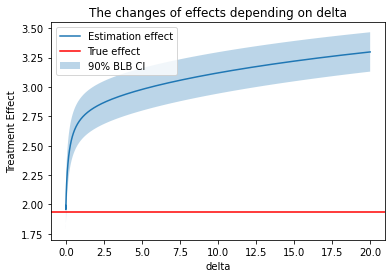

In [43]:
from matplotlib import pyplot as plt

fig = plt.figure()
plt.plot(delta_seq, means_train, label='Estimation effect')
plt.axhline(y=true_effect_train, color='r', linestyle='-', label = "True effect")
plt.fill_between(np.array(delta_seq).reshape(-1), lowers_train, uppers_train, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(cf.FIGURE_PATH + '/a_b_testing_train.png')


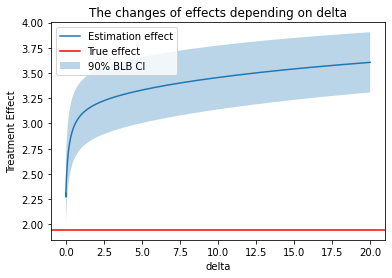

In [45]:
figure_path = "/home/dtd/Documents/PhD_Life/Source Code/my_work/figure"
plt.plot(delta_seq, means_test, label='Estimation effect')
plt.axhline(y=true_effect_test, color='r', linestyle='-', label = "True effect")
plt.fill_between(np.array(delta_seq).reshape(-1), lowers_test, uppers_test, label="90% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("delta")
plt.title("The changes of effects depending on delta")
plt.legend()
plt.show()
fig.savefig(cf.FIGURE_PATH + '/a_b_testing_test.png')


In [ ]:
-----

## Optimization with list of delta

In [ ]:
# def incre_ps(delta, data):
#     q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
#     q1 = tf.math.abs(q1)
#     a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
#     a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
#     influence = a1 - a0
#     return tf.reduce_mean(influence), influence

# def optimization(data, true_effect):
#     threhold = tf.constant([0.05])
#     delta = tf.Variable(np.random.randint(low=1, high=40, size=1), 
#                         trainable = True, 
#                         dtype = tf.float32)
#     delta_seq = []
#     losses = []
#     effects = []
#     influences = []
#     for i in tqdm(range(10000)):
#         with tf.GradientTape() as tape:
#             mu_influence, influence = incre_ps(delta, data)
#             loss = tf.losses.MAE(true_effect, influence)
#             d_delta = tape.gradient(loss, delta)
#             opt = tf.keras.optimizers.Adam(learning_rate=0.01)
#             opt.apply_gradients(zip([d_delta], [delta]))
#             if tf.math.less(loss, threhold):
#                 print("The performance reach MAE: 0.001. Cancelling the training at step {}".format(i))
#                 break
#             delta_seq.append(delta.numpy())
#             losses.append(loss.numpy())
#             effects.append(mu_influence.numpy())
#             influences.append(influence.numpy())
#         if i % 1000 == 0:
#             print("Epoch {}. Loss {:.4f}".format(i, loss))
#     print("Loss {:.3f}".format(loss))
#     print("Effects ", influence)
#     return delta, delta_seq, losses, effects, influences

def incre_ps(delta, data):
    q1 = (delta * data['p1']) / (delta * data['p1'] + data['p0'])
    q1 = tf.math.abs(q1)
    a0 = (1-q1)*data['w0']*(data['cf0'] - data[outcome])
    a1 = q1*data['w1']*(data['cf1'] - data[outcome])    
    influence = a1 - a0
    return tf.reduce_mean(influence), influence

def optimization(train, test, true_effect):
    threhold = tf.constant([0.05])
    delta = tf.Variable(np.random.randint(low=1, high=40, size=1), 
                        trainable = True, 
                        dtype = tf.float32)
    delta_seq = []
    losses = []
    losses_test = []
    effects_train = []
    effects_test = []
    influences_train = []
    influences_test = []
    for i in tqdm(range(10000)):
        with tf.GradientTape() as tape:
            mu_influence_train, influence_train = incre_ps(delta, train)
            mu_influence_test, influence_test = incre_ps(delta, test)
            loss = loss = tf.losses.MAE(true_effect, influence_train)
            loss_test = tf.math.abs(true_effect - mu_influence_test)
            d_delta = tape.gradient(loss, delta)
            opt = tf.keras.optimizers.Adam(learning_rate=0.01)
            opt.apply_gradients(zip([d_delta], [delta]))
            ## early stopping 
            if tf.math.less(loss, threhold):
                print("The performance reach MAE: 0.001. Cancelling the training at step {}".format(i))
                break
            delta_seq.append(delta.numpy())
            losses.append(loss.numpy())
            losses_test.append(loss_test.numpy())
            effects_train.append(mu_influence_train.numpy())
            effects_test.append(mu_influence_test.numpy())
            influences_train.append(influence_train.numpy())
            influences_test.append(influence_test.numpy())
        if i % 1000 == 0:
            print("Epoch {}. Loss {:.4f}".format(i, loss))
            print(influence_test.shape)
    print("Loss {:.3f}".format(loss))
    return delta, delta_seq, losses, losses_test, influences_train, influences_test

In [ ]:
true_effect = TE_fn(train[cov])
delta, delta_seq, losses, losses_test, influences_train, influences_test = optimization(train, test, true_effect)